# **The Navier-Stokes equations - ALE**

Template by **Johan Hoffman**

Lab report by **Giuseppe Anagni**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations using an ALE method, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

The flow problem is analyzed in different cases, for a cylinder deforming in three possible ways. The results are analyzed and compared.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License v2.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time Arbitrary Lagrangian-Eulerian (ALE) finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$$(\dot u + ((u-m)\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term. The mesh velocity is denoted by m.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

The function $\texttt{lab4_ALE}$ is defined and takes as input the two boolean variables $\texttt{Still}$ and $\texttt{Flap}$, which determine if the cylinder is deforming while staying still or while moving, and if its motion is trying to mimic a flapping wing.

Regarding the latter, the deformation $w$ is modified in order to draw the figure of an $8$ over the domain, combining two periodic $\sin()$ functions with amplitudes of different sign.

For the former cases, there is no horizontal movement and the only difference is that the second $\sin()$ function used, which determines the movement of the center of the cylinder, forces the movement to be zero when the center of the cylinder is considered: $y=H/2$.

The function outputs the lift and drag coefficients as a function of time, upon which the comparison between all cases is made in the **Results** section.

In [ ]:
def lab4_ALE(Still, Flap):

  ########## Define domain and mesh ##########

  # Define rectangular domain
  L = 4
  H = 2

  # Define circle
  xc = 1.0
  yc = 0.5*H
  rc = 0.2

  # Define subdomains (for boundary conditions)
  class Left(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], 0.0)

  class Right(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], L)

  class Lower(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], 0.0)

  class Upper(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], H)

  left = Left()
  right = Right()
  lower = Lower()
  upper = Upper()

  # Generate mesh (examples with and without a hole in the mesh)
  resolution = 32
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

  # ### Vertices of a wing-like polygonal domain
  # wing_vertices = [Point(4.4/3,3.5/3), Point(4.0/3,3.7/3), Point(3.0/3,4.0/3),
  #                  Point(2.3/3,3.7/3), Point(2.3/3,3.7/3), Point(3.0/3,3.3/3),
  #                  Point(4.0/3,3.1/3), Point(5.0/3,2.8/3)]

  # wing = Polygon(wing_vertices)
  # mesh = generate_mesh(Rectangle(Point(0.0, 0.0), Point(4, 2)) - wing, resolution)

  # Local mesh refinement (specified by a cell marker)
  no_levels = 0
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(xc, yc)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)

  ########## Define finite element approximation spaces ##########

  # Generate finite element spaces (for velocity and pressure)
  V = VectorFunctionSpace(mesh, "Lagrange", 1)
  Q = FunctionSpace(mesh, "Lagrange", 1)

  # Define trial and test functions
  u = TrialFunction(V)
  p = TrialFunction(Q)
  v = TestFunction(V)
  q = TestFunction(Q)

  ########## Define boundary conditions ##########

  class DirichletBoundaryLower(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], 0.0)

  class DirichletBoundaryUpper(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], H)

  class DirichletBoundaryLeft(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], 0.0)

  class DirichletBoundaryRight(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], L)

  class DirichletBoundaryObjects(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  # Examples of time dependent and stationary inflow conditions
  #uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
  #uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
  uin = 1.0
  bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
  bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

  pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
  pout = 0.0
  #bcp0 = DirichletBC(Q, pin, dbc_left)
  bcp1 = DirichletBC(Q, pout, dbc_right)

  #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
  bcp = [bcp1]

  # Define measure for boundary integration
  ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

  ########## Define flow parameters ##########

  # Set viscosity
  nu = 4.0e-3

  ########## Define method parameters ##########

  # Define iteration functions
  # (u0,p0) solution from previous time step
  # (u1,p1) linearized solution at present time step
  u0 = Function(V)
  u1 = Function(V)
  p0 = Function(Q)
  p1 = Function(Q)

  # Define mesh deformation w, mesh velocity = w/dt
  ### Deformation while standing still
  if Still:
    amp_x = 0.0
    amp_y = 1.0e-2
    freq = 0.1
    t = 0.0
    w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]*2/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())
  else:
    amp_x = 0.0
    amp_y = 1.0e-2
    freq = 0.1
    t = 0.0
    w = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

  if Flap:
    amp_x = 1.0e-2
    amp_y = 1.0e-2
    freq = 0.1
    t = 0.0
    w = Expression(("-amp_x*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[0]/(L/2))","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)"), L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

  # Set parameters for nonlinear and lienar solvers
  num_nnlin_iter = 5
  prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

  # Time step length
  dt = 0.5*mesh.hmin()

  ########## Define variational problem ##########

  # Stabilization parameters
  h = CellDiameter(mesh);
  u_mag = sqrt(dot(u1,u1))
  d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
  d2 = h*u_mag

  # Mean velocities for trapozoidal time stepping
  um = 0.5*(u + u0)
  um1 = 0.5*(u1 + u0)

  # Momentum variational equation on residual form
  Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
      + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + grad(p1), grad(v)*(um1-w/dt))*dx + d2*div(um)*div(v)*dx
  au = lhs(Fu)
  Lu = rhs(Fu)

  # Continuity variational equation on residual form
  Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx
  ap = lhs(Fp)
  Lp = rhs(Fp)

  ########## Compute forces on boundary ##########

  ###### Lift force ######
  phi_x = 0.0
  phi_y = 1.0

  #psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
  psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
  psi = interpolate(psi_expression, V)

  LiftForce = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

  ###### Drag force ######
  phi_x = 1.0
  phi_y = 0.0

  #psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
  psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
  psi = interpolate(psi_expression, V)

  DragForce = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

  ### Forces normalization term
  D = 2*rc
  normalization = -2.0/D

  ########## Set plotting variables and open export files ##########

  # Open files to export solution to Paraview
  file_u = File("results-NS/u.pvd")
  file_p = File("results-NS/p.pvd")

  # Set plot frequency
  plot_time = 0
  plot_freq = 7

  # Force computation data
  lift_force_array = np.array(0.0)
  lift_force_array = np.delete(lift_force_array, 0)
  drag_force_array = np.array(0.0)
  drag_force_array = np.delete(drag_force_array, 0)
  time = np.array(0.0)
  time = np.delete(time, 0)
  start_sample_time = 1.0

  ########## Time stepping algorithm ##########

  !rm results-NS/*

  # Time stepping
  T = 30
  t = dt

  while t < T + DOLFIN_EPS:

      #s = 'Time t = ' + repr(t)
      #print(s)

      pin.t = t
      #uin.t = t

      w.t = t
      ALE.move(mesh, w)

      # Solve non-linear problem
      k = 0
      while k < num_nnlin_iter:

          # Assemble momentum matrix and vector
          Au = assemble(au)
          bu = assemble(Lu)

          # Compute velocity solution
          [bc.apply(Au, bu) for bc in bcu]
          [bc.apply(u1.vector()) for bc in bcu]
          solve(Au, u1.vector(), bu, "bicgstab", "default")

          # Assemble continuity matrix and vector
          Ap = assemble(ap)
          bp = assemble(Lp)

          # Compute pressure solution
          [bc.apply(Ap, bp) for bc in bcp]
          [bc.apply(p1.vector()) for bc in bcp]
          solve(Ap, p1.vector(), bp, "bicgstab", prec)

          ### Compute Lift and Drag force
          F_Lift = assemble(LiftForce)
          F_Drag = assemble(DragForce)
          if (t > start_sample_time):
            lift_force_array = np.append(lift_force_array, normalization*F_Lift)
            drag_force_array = np.append(drag_force_array, normalization*F_Drag)
            time = np.append(time, t)

          k += 1

      if t > plot_time:

          s = 'Time t = ' + repr(t)
          print(s)

          # Save solution to file
          file_u << u1
          file_p << p1

          #Plot solution
          fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(14, 16))
          plt.sca(axs[0])
          plot(u1, title="Velocity")
          plt.sca(axs[1])
          plot(p1, title="Pressure")
          plt.sca(axs[2])
          plot(mesh, title="Mesh")
          for ax in fig.get_axes():
            ax.label_outer()

          plot_time += T/plot_freq
          plt.show()

      # Update time step
      u0.assign(u1)
      t += dt

  # !tar -czvf results-NS.tar.gz results-NS
  # files.download('results-NS.tar.gz')

  return time, lift_force_array, drag_force_array

# **Results**

First, the case for a deforming *and* moving cylinder is considered. In the figures below, some snapshots of the $30$ seconds long simulation can be observed for the velocity and pressure fields, as well as for the meshed domain.

Note how the mesh is refined in the most interesting zones of the domain: in the moving cylinder's proximity and towards the direction it's currently heading towards.

Also note how, by looking at pressure and velocity, a Von Kármán vortex street can be clearly observed downstream of the cylinder.

In [ ]:
[Time1, Lift1, Drag1] = lab4_ALE(False, False)

Output hidden; open in https://colab.research.google.com to view.

Then, the pressure and velocity fields, and the deforming mesh, are plotted for the case of a cylinder that deforms while its center stays still at $(x_c,y_c)=(1,1)$.

The boucing frequency and amplitude are the same as before, with the only difference that the center of the cylinder does not move with its edges.

Now the domain has a finer resolution in the cylinder's wake when its shape is squished vertically, while the resolution increases on the boundary and appears coarser near the cylinder whenever the shape becomes elongated vertically.

The pressure and velocity fields for the deforming cylinder appear quite different from before, with no vortex street downstream of the shape and the unusual behaviour of an alternating streamlined/blunt body.

In [ ]:
[Time2, Lift2, Drag2] = lab4_ALE(True, False)

Output hidden; open in https://colab.research.google.com to view.

The (non-dimensionalized) lift and drag forces are plotted in the figure below, such that a different behavior can be observed for the two cases.

For the cylinder moving and deforming, both forces oscillate periodically and with comparable amplitude.
Although drag is always positive since the flow goes left to right, along the $x$ direction, lift changes sign during the considered time interval, as the cylinder is periodically pushed upwards/downwards by the pressure being higher in atlernating lower/upper surfaces of the cylinder.

The still cylinder was seen to appear like an alternating streamlined/blunt body before, and this behaviour is reflected in the observed forces, with lift increasing rapidly for a streamlined shape and decreasing whenever the cylinder becomes a bigger obstacle to the fluid.
This is observed even more clearly by looking at the drag, which increases dramatically to an order of magnitude higher than the other cases whenever the flow encounters a stretched, blunt shape.

Drag can also be observed to oscillate more in the moving case, another sign of the presence of a Von Kármán vortex street.

Text(0.5, 1.0, 'Drag force, still cylinder')

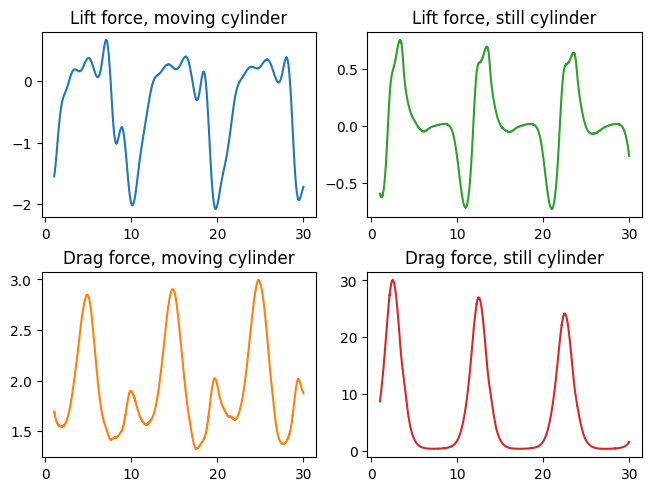

In [ ]:
fig, axs = plt.subplots(2, 2, layout="constrained")
axs[0,0].plot(Time1, Lift1)
axs[0,0].set_title('Lift force, moving cylinder')
axs[0,1].plot(Time2, Lift2, 'tab:green')
axs[0,1].set_title('Lift force, still cylinder')

axs[1,0].plot(Time1, Drag1, 'tab:orange')
axs[1,0].set_title('Drag force, moving cylinder')
axs[1,1].plot(Time2, Drag2, 'tab:red')
axs[1,1].set_title('Drag force, still cylinder')

Finally, the main function is called once again to try and mimic the dynamics of a flapping wing by moving and deforming the cylinder around the domain.

The desired movement of the cylinder is a combined heave (vertical translation) and pitch (orientation of the angle of attack) motion, although a pitching motion cannot be accurately represented for a symmetric cylinder.
However, the simulation of a flapping motion is possible if the cylinder moves through the domain by shaping a $8$ and deforming in the meantime. This is achieved by modifying the deformation $w$ as explained previously.

By looking at the lift and drag coefficients it's possible to observe an increase in lift and subsequent decrease in drag compared to the previous cases, even if frequency, amplitude and the overall form of the functions that define $w$ are quite the same.
In particular, lift has higher peaks and it's negative when the cylinder mimics an heaving motion oriented upwards, while it returns positive while "flapping" downwards. Drag, instead, presents lower peaks.
Such results hint at the efficiency of flapping flight in the right conditions.

The vortex street persists in this new case.

In [ ]:
[Time3, Lift3, Drag3] = lab4_ALE(False, True)

Output hidden; open in https://colab.research.google.com to view.

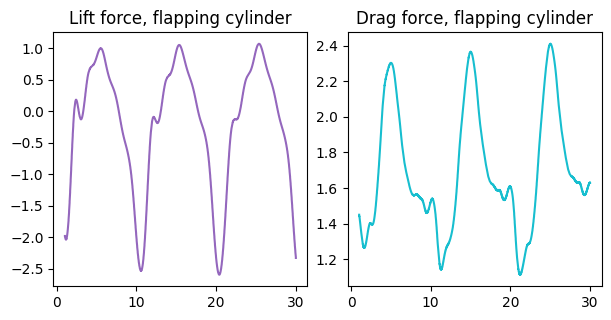

In [ ]:
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(6,8))
axs[0].plot(Time3, Lift3, 'tab:purple')
axs[0].set_title('Lift force, flapping cylinder')
axs[0].set_box_aspect(1)
axs[1].plot(Time3, Drag3, 'tab:cyan')
axs[1].set_title('Drag force, flapping cylinder')
axs[1].set_box_aspect(1)

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D using an ALE finite element method.

The cylinder was moved and deformed in three ways, which gave rise to different behaviour of the lift and drag coefficients as a function of time.
In particular, a somewhat enhanched performance (more lift and less drag) was observed for a flapping cylinder, although its motion wasn't represented with great accuracy.